In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

import seisbench
import seisbench.data as sbd
import seisbench.generate as sbg

from tqdm.auto import tqdm

from xgboost import XGBRegressor, XGBClassifier

import tsfel
from geographiclib.geodesic import Geodesic

import sktime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
data = sbd.STEAD(component_order='ZNE')#, cache='trace')
train = data.train()
test = data.test()
print(train)
print(test)

STEAD - 1075808 traces
STEAD - 126566 traces


In [4]:
def read_snr(x):
    x = x[1:-1]
    return [float(i) for i in x.split(" ") if i != ""]

In [5]:
def filter_data(data):
    data.filter(data.metadata["source_distance_km"] <= 110)
    data.filter(data.metadata["source_magnitude_type"] == 'ml')
    data.filter(data.metadata["trace_p_arrival_sample"] >= 200)
    data.filter(data.metadata["trace_p_arrival_sample"]+2900 <= 6000)
    data.filter(data.metadata["trace_p_arrival_sample"] <= 1500)
    data.filter(data.metadata["trace_s_arrival_sample"] >= 200)
    data.filter(data.metadata["trace_s_arrival_sample"] <= 2500)
    data.filter(data.metadata["path_p_travel_sec"].notnull())
    data.filter(data.metadata["path_p_travel_sec"] > 0)
    data.filter(data.metadata["source_distance_km"].notnull())
    data.filter(data.metadata["source_distance_km"] > 0)
    data.filter(data.metadata["source_distance_km"] < 110)
    data.filter(data.metadata["source_depth_km"].notnull())
    data.filter(data.metadata["source_magnitude"].notnull())
    data.filter(data.metadata["source_magnitude"] > 2.5)
    data.filter(data.metadata["path_back_azimuth_deg"].notnull())
    data.metadata["trace_snr_db"] = data.metadata["trace_snr_db"].apply(lambda x: np.mean(read_snr(x)))
    data.filter(data.metadata["trace_snr_db"] >= 20)

filter_data(train)
filter_data(test)

In [6]:
print(train)
print(test)

STEAD - 40440 traces
STEAD - 4673 traces


In [7]:
train_generator = sbg.GenericGenerator(train)
test_generator = sbg.GenericGenerator(test)

@train_generator.augmentation
def add_back_azimuth_deg(state_dict):
    state_dict["angle"] = (state_dict['X'][1]["path_back_azimuth_deg"]/360, None)

@test_generator.augmentation
def add_back_azimuth_deg(state_dict):
    state_dict["angle"] = (state_dict['X'][1]["path_back_azimuth_deg"]/360, None)

augmentations = [
    #sbg.ProbabilisticLabeller(label_columns=["trace_p_arrival_sample"], sigma=50, dim=-2),
    #sbg.ProbabilisticLabeller(label_columns=["trace_s_arrival_sample"], sigma=50, dim=-2),
    sbg.ChangeDtype(np.float32),
]
train_generator.add_augmentations(augmentations)
test_generator.add_augmentations(augmentations)

train_generator.augmentation(sbg.ProbabilisticLabeller(label_columns=["trace_P1_arrival_sample"], sigma=50, dim=-2))

In [8]:
train_loader = DataLoader(train_generator, batch_size=32, shuffle=True)
test_loader = DataLoader(test_generator, batch_size=1, shuffle=False)

In [9]:
def sincos_eager(x):
    return torch.cat([x.cos().unsqueeze(0), x.sin().unsqueeze(0)], axis=0).T

In [10]:
device = 'mps'

In [16]:
class CNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(in_channels=3, out_channels=64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=4),
            nn.Flatten(),
            nn.Linear(64 * 4, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        
    def forward(self, x):
        return self.model(x).squeeze()

    def fit(self, X, n_epochs=10, lr=0.000001):
        criterion = nn.L1Loss()
        optimizer = optim.AdamW(self.parameters(), lr=lr)
        losses = []
        for epoch in range(n_epochs):
            self.train()
            total_loss = 0.0
            for item in (pbar:=tqdm(X)):
                inputs, targets = item['X'].to(device), sincos_eager(item['angle'].to(device, dtype=torch.float32))
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
                pbar.set_description(f"%.5f"%np.mean(losses[-25:]))
                
    def test(self, X, n=-1):
        self.eval()
        y, y_hat = [], []
        i = 0
        for item in (pbar:=tqdm(X)):
            inputs, targets = item['X'].to(device), sincos_eager(item['angle'].to(device, dtype=torch.float32))
            outputs = self(inputs)
            y.append(item['angle'][0])
            if outputs[0].item() ==0:
                y_hat.append(np.arcsin(outputs[1].item()))
            else:
                y_hat.append(np.arctan(outputs[1].item()/outputs[0].item()))
            i += 1
            if i == n:
                break
        return np.array(y), np.array(y_hat)

In [17]:
model = CNNRegressor().to(device)

In [18]:
model.fit(train_loader, n_epochs=30)

  0%|          | 0/1264 [00:00<?, ?it/s]

  0%|          | 0/1264 [00:00<?, ?it/s]

  0%|          | 0/1264 [00:00<?, ?it/s]

  0%|          | 0/1264 [00:00<?, ?it/s]

  0%|          | 0/1264 [00:00<?, ?it/s]

  0%|          | 0/1264 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
y, y_hat = model.test(test_loader, 100)

  0%|          | 0/4673 [00:00<?, ?it/s]

Text(0, 0.5, 'Predicted angle')

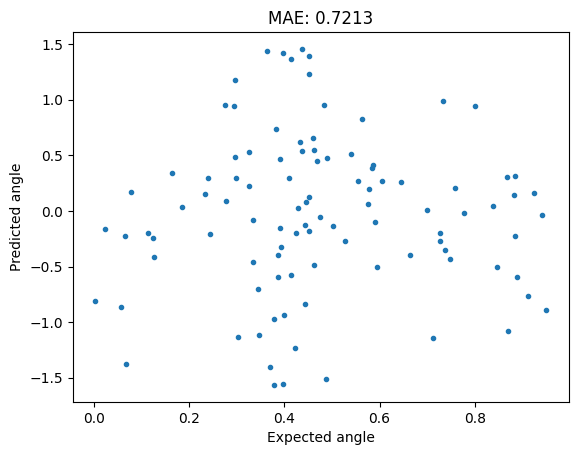

In [24]:
plt.scatter(y, y_hat, marker='.')
plt.title(f"MAE: %.4f"%np.mean(np.abs(y-y_hat)))
plt.xlabel("Expected angle")
plt.ylabel("Predicted angle")